In [1]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

wandb: Currently logged in as: chucooleg (use `wandb login --relogin` to force relogin)


## Data -- Generation

In [2]:
def generate_strings_data(str_len=5):
    strings = []
    for i in range(2**str_len):
        bit_repr = "{0:b}".format(i).zfill(5)
        ones = bit_repr.count('1')
        strings.append((bit_repr, ones))
        
    idx_to_string = {i:string for i,string in enumerate(strings)} 
    string_to_idx = {string:i for i,string in enumerate(strings)}
    idx_to_key, idx_to_query = idx_to_string, idx_to_string
    key_to_idx, query_to_idx = string_to_idx, string_to_idx
    
    query_to_keys = {}
    for i in range(len(idx_to_key)):
        for j in range(len(idx_to_query)):
            if idx_to_string[i][1] == idx_to_string[j][1]: # match
                if j not in query_to_keys: # start new list
                    query_to_keys[j] = {}
                query_to_keys[j][i] = idx_to_string[j][1] # idx, num matches
    
    data = {
        'idx_to_key': idx_to_key,
        'key_to_idx': key_to_idx,
        'idx_to_query': idx_to_query,
        'query_to_idx': query_to_idx,
        'query_to_keys': query_to_keys,
    }
    
    return data

string_length = 6
game_data = generate_strings_data(string_length)

## Data -- Distribution, Splits

In [3]:
count_table = np.zeros((2**string_length, 2**string_length))

for i in range(2**string_length):
    for j in range(2**string_length): 
        count_table[i][j] = int(game_data['idx_to_key'][i][1] == game_data['idx_to_query'][j][1])
        
xy = count_table/np.sum(count_table)
# xy += 1e-9
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [4]:
Counter(list(xy.reshape(-1))).most_common()

[(0.0, 3172), (0.0010822510822510825, 924)]

In [5]:
np.sum(count_table)

924.0

In [6]:
np.linalg.matrix_rank(xy)

7

In [7]:
np.linalg.matrix_rank((xy/xyind))

7

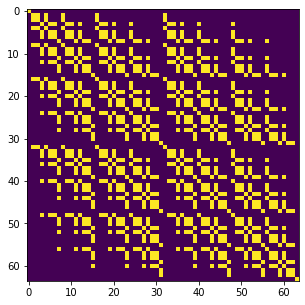

In [8]:
# all
plt.figure(figsize = (5,5))
plt.imshow((xy)[:, :])

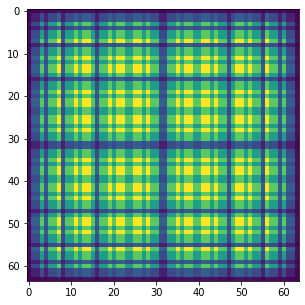

In [9]:
# all
plt.figure(figsize = (5,5))
plt.imshow((xyind)[:, :])

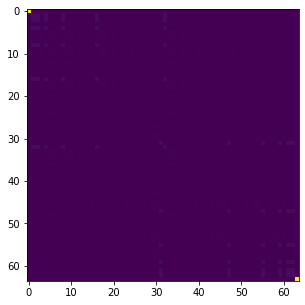

In [10]:
# all
plt.figure(figsize = (5,5))
plt.imshow((xy/xyind)[:, :300])

In [11]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.0, 3172),
 (4.106666666666667, 450),
 (2.3099999999999996, 400),
 (25.666666666666668, 72),
 (923.9999999999999, 2)]

## Dataset

In [12]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            print('query\n', y_j, self.raw_data['idx_to_query'][y_j])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[7]

query
 7 ('00111', 3)
key
 0 ('00000', 0)
all matches 
 [('00111', 3), ('01011', 3), ('01101', 3), ('01110', 3), ('10011', 3), ('10101', 3), ('10110', 3), ('11001', 3), ('11010', 3), ('11100', 3), ('100011', 3), ('100101', 3), ('100110', 3), ('101001', 3), ('101010', 3), ('101100', 3), ('110001', 3), ('110010', 3), ('110100', 3), ('111000', 3)]


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

In [13]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            print('query\n', y_j, self.raw_data['idx_to_query'][y_j])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[7]

query
 7 ('00111', 3)
all matches 
 [('00111', 3), ('01011', 3), ('01101', 3), ('01110', 3), ('10011', 3), ('10101', 3), ('10110', 3), ('11001', 3), ('11010', 3), ('11100', 3), ('100011', 3), ('100101', 3), ('100110', 3), ('101001', 3), ('101010', 3), ('101100', 3), ('110001', 3), ('110010', 3), ('110100', 3), ('111000', 3)]


(7,
 tensor([7]),
 tensor([0]),
 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
         0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

In [14]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
        self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
        if stage == 'test' or stage is None:
            self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
    def test_dataloader(self):
        test_loader = DataLoader(
            self.test, batch_size=self.batch_size, shuffle=False
        )
        return test_loader  

## Training Module

In [15]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions, raw_data):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = ThresholdedMetrics(raw_data=raw_data)

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, test_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, test_bool, debug=debug)
        # scalar
        loss = None if test_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, breakdown_errors_bool=True, 
        ) if test_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, test_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, test_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, test_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, test_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif 'count' in m or 'rate' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics        
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## Model Architecture

In [16]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [17]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [18]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, test_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if test_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [19]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [20]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
            
        error_count_by_num_matched_concepts = \
            Counter((num_matched_concepts * wrongs).reshape(-1).tolist())
        
        total_count_by_num_matched_concepts = \
            Counter((num_matched_concepts).reshape(-1).tolist())        
        
        error_counts = {f'error_rate_for_{k}_matched_concepts':error_count_by_num_matched_concepts[k]/total_count_by_num_matched_concepts[k] for k in error_count_by_num_matched_concepts.keys() if k!=0}
        total_counts = {f'total_count_for_{k}_matched_concepts':total_count_by_num_matched_concepts[k] for k in total_count_by_num_matched_concepts.keys() if k!=0}
        
        return {**error_counts, **total_counts}
        
    def forward(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)
        
        
        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by__QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## hparams, init train module

In [21]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 8,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind}, raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 1.0 K 
1  | model.inp_query_layer                        | Sequential         | 512   
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 512   
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 512   
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 512   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 512   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 512   
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [22]:
# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = f'CountOnes-6digits-dotproduct;params1.0 K'
project_name = 'ContrastiveLearning-cardgame-Scaling'

wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)

# trainer
trainer = pl.Trainer(
    gpus=[0], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    # track_grad_norm
)

# fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


RUN NAME :
 CountOnes-6digits-dotproduct;params1.0 K


<ipython-input-22-defb1f25d15b>:31: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():



   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 1.0 K 
1  | model.inp_query_layer                        | Sequential         | 512   
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 512   
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 512   
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 512   
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 512   
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 512   
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                     

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=624, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Validating:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=624, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=624, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=624, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=624, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=624, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=624, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=624, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=624, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10:  50%|█████     | 

Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 43:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=622, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 44:  50%|████

Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=619, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=619, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=619, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=618, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=618, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=617, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=617, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=617, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 77:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=617, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 78:  50%|████

Epoch 103:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=611, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 104:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=611, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 105:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=611, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 106:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=611, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 107:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=611, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 108:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=610, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 109:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=610, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 110:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=609, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 111:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=609, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 112:

Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=600, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=599, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 139:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=599, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 140:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=599, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=598, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=598, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=597, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 144:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=596, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 145:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=596, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 146:

Validating: 0it [00:00, ?it/s]
Epoch 172:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=579, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 173:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=579, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 174:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=578, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 175:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=578, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 176:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=577, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 177:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=576, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 178:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=576, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 179:  50%|█████     | 1/2 [00:00<00:00,  9.04it/s, loss=575, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 180:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=574, v_num=u1cf]
Validating

Epoch 206:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=555, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=554, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=553, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=552, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 210:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=551, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 211:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=551, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 212:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=550, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 213:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=549, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 214:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=548, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 215:

Epoch 240:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=531, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 241:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=530, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 242:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=530, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 243:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=529, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 244:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=528, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 245:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=528, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 246:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=527, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 247:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=527, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 248:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=526, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 249:

Epoch 274:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=511, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=511, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=510, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 277:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=510, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 278:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=510, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 279:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=509, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 280:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=509, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 281:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=508, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 282:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=508, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 283:

Epoch 309:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=496, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 310:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=496, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 311:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=496, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 312:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=495, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 313:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=494, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 314:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=494, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 315:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=494, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 316:  50%|█████     | 1/2 [00:00<00:00,  8.92it/s, loss=493, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 317:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=493, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 318:

Epoch 343:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=484, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 344:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=483, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 345:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=483, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 346:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=482, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 347:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=482, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 348:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=481, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 349: 100%|██████████| 2/2 [00:00<00:00,  7.88it/s, loss=481, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 350:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=480, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 351:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=481, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 352:

Epoch 377:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=476, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 378:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=475, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 379:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=475, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 380:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=475, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 381:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=474, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 382:  50%|█████     | 1/2 [00:00<00:00,  8.88it/s, loss=474, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 383:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=473, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 384:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=473, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 385:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=473, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 386:

Epoch 411:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=468, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 412:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=469, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 413:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=469, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 414:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=469, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 415:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=468, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 416:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=467, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 417:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=467, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 418:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=467, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 419:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=468, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 420:

Epoch 445:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=467, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 446:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=467, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 447:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=466, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 448:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=465, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 449: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s, loss=465, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 450:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=464, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 451:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=464, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 452:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=464, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 453:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=464, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 454:

Epoch 479:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=466, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 480:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=465, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 481:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=465, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 482:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=464, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 483:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=465, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 484:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=465, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 485:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=464, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 486:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=463, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 487:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=463, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 488:

Epoch 513:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 514:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 515:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 516:  50%|█████     | 1/2 [00:00<00:00,  8.88it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 517:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 518:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 519:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 520:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 521:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 522:

Epoch 547:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 548:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 549: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 550:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 551:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 552:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 553:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 554:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 555:  50%|█████     | 1/2 [00:00<00:00,  8.96it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 556:

Validating: 0it [00:00, ?it/s]
Epoch 581:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 582:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 583:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 584:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 585:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 586:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 587:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 588:  50%|█████     | 1/2 [00:00<00:00,  8.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 589:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=456, v_num=u1cf]
Validating

Validating: 0it [00:00, ?it/s]
Epoch 615:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 616:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 617:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 618:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 619:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 620:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 621:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 622:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 623:  50%|█████     | 1/2 [00:00<00:00,  8.87it/s, loss=461, v_num=u1cf]
Validating

Epoch 649: 100%|██████████| 2/2 [00:00<00:00,  8.69it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 650:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 651:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 652:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 653:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 654:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 655:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 656:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 657:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 658:

Epoch 683:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 684:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 685:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 686:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 687:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 688:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 689:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 690:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 691:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 692:

Epoch 717:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 718:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 719:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 720:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 721:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 722:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 723:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 724:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 725:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 726:

Epoch 752:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 753:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 754:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 755:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 756:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 757:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 758:  50%|█████     | 1/2 [00:00<00:00,  8.78it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 759:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 760:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 761:

Epoch 786:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 787:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 788:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 789:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 790:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 791:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 792:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 793:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 794:  50%|█████     | 1/2 [00:00<00:00,  8.80it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 795:

Epoch 820:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 821:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 822:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 823:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 824:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 825:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 826:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 827:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 828:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 829:

Epoch 854:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 855:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 856:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 857:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 858:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 859:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 860:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 861:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 862:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 863:

Epoch 888:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 889:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 890:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 891:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 892:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 893:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 894:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 895:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 896:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 897:

Epoch 923:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 924:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 925:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 926:  50%|█████     | 1/2 [00:00<00:00,  8.64it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 927:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 928:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 929:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 930:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 931:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 932:

Epoch 957:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 958:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 959:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 960:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 961:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 962:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 963:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 964:  50%|█████     | 1/2 [00:00<00:00,  8.85it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 965:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 966:

Epoch 990:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 991:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 992:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 993:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 994:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 995:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 996:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 997:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 998:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 999:

Epoch 1025:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1026:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1027:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1028:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1029:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1030:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1031:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1032:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1033:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1059:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1060:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1061:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1062:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1063:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1064:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1065:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1066:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1067:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1092:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1093:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1094:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1095:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1096:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1097:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1098:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1099: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1100:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1126:  50%|█████     | 1/2 [00:00<00:00,  8.81it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1127:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1128:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1129:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1130:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1131:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1132:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1133:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1134:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1159:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1160:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1161:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1162:  50%|█████     | 1/2 [00:00<00:00,  8.82it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1163:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1164:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1165:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1166:  50%|█████     | 1/2 [00:00<00:00,  8.75it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1167:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1193:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1194:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1195:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1196:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1197:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1198:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1199: 100%|██████████| 2/2 [00:00<00:00,  8.49it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1200:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1201:  50%|█████     | 1/2 [00:00<00:00,  8.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1226:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1227:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1228:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1229:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1230:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1231:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1232:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1233:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1234:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1260:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1261:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1262:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1263:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1264:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1265:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1266:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1267:  50%|█████     | 1/2 [00:00<00:00,  8.88it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1268:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=456, v_num=u1cf]
V

Epoch 1293:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1294:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1295:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1296:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1297:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1298:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1299: 100%|██████████| 2/2 [00:00<00:00,  8.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1300:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1301:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1327:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1328:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1329:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1330:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1331:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1332:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1333:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1334:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1335:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1360:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1361:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1362:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1363:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1364:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1365:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1366:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1367:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1368:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1393:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1394:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1395:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1396:  50%|█████     | 1/2 [00:00<00:00,  8.80it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1397:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1398:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1399: 100%|██████████| 2/2 [00:00<00:00,  8.88it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1426:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1427:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1428:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1429:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1430:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1431:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1432:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1433:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1434:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1460:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1461:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1462:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1463:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1464:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1465:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1466:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1467:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1468:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=456, v_num=u1cf]
V

Epoch 1493:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1494:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1495:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1496:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1497:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1498:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1499: 100%|██████████| 2/2 [00:00<00:00,  8.59it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1500:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1501:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1526:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1527:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1528:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1529:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1559:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1560:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1561:  50%|█████     | 1/2 [00:00<00:00,  8.74it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1562:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1563:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1564:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1565:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1566:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1567:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1592:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1593:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1594:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1595:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1596:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1597:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1598:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1599: 100%|██████████| 2/2 [00:00<00:00,  8.15it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1600:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1626:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1627:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1628:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1629:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1630:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1631:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1632:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1633:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1634:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=452, v_num=u1cf]
V

Epoch 1659:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1660:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1661:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1662:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1663:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1664:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1665:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1666:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1667:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1692:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1693:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1694:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1695:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1696:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1697:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1698:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1699: 100%|██████████| 2/2 [00:00<00:00,  7.86it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1700:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1725:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1726:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1727:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1728:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1729:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1730:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1731:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1758:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1759:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1760:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1761:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1762:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1763:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1764:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1765:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1766:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1792:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1793:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1794:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1795:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1796:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1797:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1799: 100%|██████████| 2/2 [00:00<00:00,  7.49it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1825:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1826:  50%|█████     | 1/2 [00:00<00:00,  8.57it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1827:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1828:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1829:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1830:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1831:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1832:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1833:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 1859:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1860:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1861:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1862:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=455, v_num=u1cf]
V

Epoch 1892:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1893:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1894:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1895:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1896:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1897:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1898:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1899: 100%|██████████| 2/2 [00:00<00:00,  7.60it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1900:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1925:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1926:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1927:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1928:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1929:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1930:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1931:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1932:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1958:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1959:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1960:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1961:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1962:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1963:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1964:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1965:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1966:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 1991:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1997:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1998:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 1999: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2024:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2025:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2026:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2027:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2028:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2029:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2030:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2031:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2032:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2057:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2058:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2059:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2060:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2061:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2062:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2063:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2064:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2065:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 2091:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2092:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2093:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2094:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2095:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2096:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2097:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2098:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2099: 100%|██████████| 2/2 [00:00<00:00,  7.14it/s, loss=452, v_num=u1cf]
V

Epoch 2124:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2125:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2126:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2127:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2128:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2129:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2130:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2131:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2132:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2157:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2158:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2159:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2160:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2161:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2162:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2163:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2164:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2165:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2190:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2191:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2192:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2193:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2194:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2195:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2196:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2197:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2198:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2223:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2224:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2225:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2226:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2227:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2228:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2229:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2230:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2231:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2256:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2257:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2258:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2259:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2260:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2261:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2262:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2263:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2264:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2289:  50%|█████     | 1/2 [00:00<00:00,  8.61it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2290:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2291:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2292:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2293:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2294:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2295:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2296:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2297:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2322:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2323:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2324:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2330:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2355:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2356:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2357:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2358:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2359:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2360:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2361:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2362:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2363:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2388:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2389:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2390:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2391:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2392:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2393:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2394:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2395:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2396:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2421:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2422:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2423:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2424:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2425:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2426:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2427:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2428:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2429:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2454:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2459:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2460:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2461:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2462:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2487:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2488:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2489:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2490:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2491:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2492:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2493:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2494:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2495:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2520:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2521:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2522:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2523:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2524:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2526:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2527:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2528:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2553:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2554:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2555:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2556:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2557:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2558:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2559:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2560:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2561:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2586:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2587:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2588:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2589:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2590:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2592:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2593:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2594:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2619:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2620:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2621:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2622:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2623:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2624:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2625:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2626:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2627:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2652:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2653:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2654:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2655:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2656:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2660:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2685:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2686:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2687:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2688:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2689:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2690:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2691:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2692:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2693:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2718:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2719:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2720:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2721:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2722:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2724:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2725:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2726:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2751:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2752:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2753:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2754:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2755:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2756:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2757:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2758:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2759:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2784:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2785:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2786:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2792:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2817:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2818:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2819:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2820:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2821:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2822:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2823:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2824:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2825:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2850:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2851:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2852:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2853:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2854:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2856:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2857:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2858:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2883:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2884:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2885:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2886:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2887:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2888:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2889:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2890:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2891:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2916:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2918:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2921:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2922:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2923:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2924:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2949: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2950:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2951:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2952:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2953:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2954:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2955:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2956:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2957:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 2982:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2983:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2984:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2985:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2986:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2987:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2988:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2989:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 2990:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3015:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3016:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3017:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3018:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3019:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3020:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3021:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3022:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3023:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3048:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3049: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3050:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3051:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3052:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3053:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3054:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3055:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3056:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3081:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3082:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3083:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3084:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3085:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3086:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3087:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3088:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3089:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3114:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3115:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3116:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3117:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3118:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3119:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3120:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3121:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3122:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3147:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3148:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3149: 100%|██████████| 2/2 [00:00<00:00,  7.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3150:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3151:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3152:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3153:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3154:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3155:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3180:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3181:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3182:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3183:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3184:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3185:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3186:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3187:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3188:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3213:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3214:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3215:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3216:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3217:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3218:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3219:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3220:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3221:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3246:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3247:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3248:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00,  6.93it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3254:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3279:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3280:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3281:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3282:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3283:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3284:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3285:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3286:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3287:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3312:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3313:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3314:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3315:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3316:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3317:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3318:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3319:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3320:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3345:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3346:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3347:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3348:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3349: 100%|██████████| 2/2 [00:00<00:00,  7.18it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3350:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3351:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3352:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3353:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3378:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3383:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3384:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3385:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3386:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3411:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3412:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3413:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3414:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3415:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3416:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3417:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3418:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3419:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3444:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3445:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3446:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3447:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3448:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3449: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3450:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3451:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3452:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3477:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3478:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3479:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3480:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3481:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3482:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3483:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3484:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3485:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3510:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3511:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3512:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3513:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3514:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3515:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3516:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3517:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3518:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3543:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3544:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3545:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3546:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3547:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3548:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3549: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3550:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3551:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3576:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3577:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3578:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3579:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3580:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3581:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3582:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3583:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3584:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3609:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3610:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3611:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3612:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3613:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3614:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3615:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3616:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3617:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3642:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3643:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3644:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3645:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3646:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3647:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3648:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3649: 100%|██████████| 2/2 [00:00<00:00,  7.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3650:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3675:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3676:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3677:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3678:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3679:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3680:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3681:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3682:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3683:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3708:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3709:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3710:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3716:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3741:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3742:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3743:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3744:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3745:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3746:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3747:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3748:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3749: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3774:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3775:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3776:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3777:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3778:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3779:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3780:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3781:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3782:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3807:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3808:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3809:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3810:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3811:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3812:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3813:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3814:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3815:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3840:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3842:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3844:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3845:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3846:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3847:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3848:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3873:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3874:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3875:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3876:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3877:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3878:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3879:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3880:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3881:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3906:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3907:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3908:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3909:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3910:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3911:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3912:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3913:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3914:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3939:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3940:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3941:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3942:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3943:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3944:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3945:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3946:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3947:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 3972:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3973:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3974:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3975:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3976:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3977:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3978:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3979:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 3980:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4005:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4006:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4007:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4008:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4009:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4010:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4011:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4012:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4013:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4038:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4039:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4040:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4041:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4042:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4043:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4044:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4045:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4046:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4071:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4072:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4073:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4074:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4075:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4076:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4077:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4078:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4079:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4104:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4105:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4106:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4107:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4108:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4109:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4110:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4111:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4112:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4137:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4138:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4139:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4140:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4141:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4142:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4143:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4144:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4145:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4170:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4171:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4172:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4178:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4203:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4204:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4205:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4206:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4207:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4208:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4209:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4210:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4211:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4236:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4237:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4238:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4239:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4240:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4241:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4242:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4243:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4244:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4269:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4270:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4271:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4272:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4273:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4274:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4275:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4276:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4277:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4302:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4304:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4307:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4308:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4309:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4310:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4335:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4336:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4337:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4338:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4339:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4340:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4341:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4342:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4343:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4368:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4369:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4370:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4371:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4372:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4373:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4374:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4375:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4376:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4401:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4402:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4403:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4404:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4405:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4406:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4407:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4408:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4409:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4434:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4435:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=450, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4436:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4437:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4438:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=450, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4439:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4440:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4441:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4442:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4467:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4468:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4469:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4470:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4471:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4472:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4473:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4474:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4475:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4500:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4501:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4502:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4503:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4504:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4505:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4506:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4507:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4508:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4533:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4534:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4535:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4536:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4537:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4538:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4539:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4540:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4541:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4566:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4567:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4568:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4569:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4570:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4571:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4572:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4573:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4574:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4599: 100%|██████████| 2/2 [00:00<00:00,  7.70it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4600:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4601:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4602:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4603:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4604:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4605:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4606:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4607:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4632:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4633:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4634:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4637:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4638:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4640:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4665:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4666:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4667:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4668:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4669:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4670:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4671:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4672:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4673:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4698:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4699: 100%|██████████| 2/2 [00:00<00:00,  7.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4700:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4701:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4702:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4703:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4704:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4705:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4706:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4731:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4732:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4733:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4734:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4735:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4736:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4737:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4738:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4739:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4764:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4765:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4766:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4767:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4768:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4769:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4770:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4771:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4772:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4797:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4798:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4799: 100%|██████████| 2/2 [00:00<00:00,  7.28it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4800:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4801:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4802:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4803:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4804:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4805:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4830:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4831:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4832:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4833:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4834:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4835:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4836:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4837:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4838:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4863:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4864:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4865:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4866:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4867:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4868:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4869:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4870:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4871:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4896:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4897:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4898:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4899: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4900:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4901:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4902:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4903:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4904:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4929:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4930:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4931:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4932:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4933:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4934:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4935:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4936:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4937:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4962:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4963:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4964:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4965:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4966:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4967:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4968:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4969:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4970:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 4995:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4996:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4997:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4998:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 4999: 100%|██████████| 2/2 [00:00<00:00,  7.27it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5000:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5001:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5002:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5003:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5028:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5029:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5030:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5031:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5032:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5033:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5034:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5035:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5036:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5061:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5062:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5063:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5064:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5065:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5066:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5067:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5068:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5069:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5094:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5095:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5096:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5097:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5098:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5099: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5100:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5101:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5102:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5127:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5128:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5129:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5130:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5131:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5132:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5133:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5134:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5135:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5160:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5161:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5162:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5163:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5164:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5165:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5166:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5167:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5168:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5193:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5194:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5195:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5196:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5197:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5198:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5199: 100%|██████████| 2/2 [00:00<00:00,  6.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5200:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5201:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5226:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5227:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5228:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5229:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5230:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5231:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5232:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5233:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5234:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5259:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5260:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5261:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5262:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5263:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5264:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=450, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5265:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=450, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5266:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5267:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5292:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5293:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5294:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5295:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5296:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5297:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5298:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5299: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5300:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5325:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5326:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5327:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5328:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5329:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5330:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5331:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5332:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5333:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5358:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5359:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5360:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5361:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5362:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5363:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5364:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5365:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5366:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5391:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5392:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5393:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5394:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5395:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5396:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5397:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5398:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5399: 100%|██████████| 2/2 [00:00<00:00,  7.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5424:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5425:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5426:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5427:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5428:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5429:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5430:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5431:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5432:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5457:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5458:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5459:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5460:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5461:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5462:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5463:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5464:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5465:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5490:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5491:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5492:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5493:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5494:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5495:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5496:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5497:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5498:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5523:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5524:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5525:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5526:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5527:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5528:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5529:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5530:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5531:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5556:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5557:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5558:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5559:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5560:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5561:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5562:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5563:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5564:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5589:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5590:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5591:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5592:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5593:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5594:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5595:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5596:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5597:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5622:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5623:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5624:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5625:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5626:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5627:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5628:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5629:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5630:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5655:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5656:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5657:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5658:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5659:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5660:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5661:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5662:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5663:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5688:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5689:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5690:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5691:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5692:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5693:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5694:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5695:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5696:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5721:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5722:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5723:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5724:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5725:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5726:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5727:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5728:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5729:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5754:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5755:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5756:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5757:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5758:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5759:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5760:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5761:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5762:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5787:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5788:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5789:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5790:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5791:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5792:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5793:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5794:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5795:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5820:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5821:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5822:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5823:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5824:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5825:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5826:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5827:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5828:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5853:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5854:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5855:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5856:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5857:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5858:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5859:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5860:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5861:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5886:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5887:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5888:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5889:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5890:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5891:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=450, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5892:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=450, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5893:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=449, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5894:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=449, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5919:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5920:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5921:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5922:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5923:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5924:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5925:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5926:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5927:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5952:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5953:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5954:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5955:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5956:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5957:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5958:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5959:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5960:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 5985:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5986:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5987:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5988:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5989:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5990:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5991:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5992:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 5993:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6018:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6019:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6020:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6021:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6022:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6023:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6024:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6025:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6026:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6051:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6052:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6053:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6054:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6055:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6056:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6057:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6058:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6059:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6084:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6085:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6086:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6087:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6088:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6089:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6090:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6091:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6092:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6117:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6118:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6119:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6120:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6121:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6122:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6123:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6124:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6125:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6150:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6151:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6152:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6153:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6154:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6155:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6156:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6157:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6158:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6183:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6184:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6185:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6186:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6187:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6188:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6189:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6190:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6191:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6216:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6217:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6218:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6219:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6220:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6221:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6222:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6223:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6224:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6249: 100%|██████████| 2/2 [00:00<00:00,  8.25it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6250:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6251:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6252:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6253:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6254:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6255:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6256:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6257:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6282:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6283:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6284:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6285:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6286:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6287:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6288:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6289:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6290:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6315:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6316:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6317:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6318:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6319:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6320:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6321:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6322:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6323:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6348:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6349: 100%|██████████| 2/2 [00:00<00:00,  7.28it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6350:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6351:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6352:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6353:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6354:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6355:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6356:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6381:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6382:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6383:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6384:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6385:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6386:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6387:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6388:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6389:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6414:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6415:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6416:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6417:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6418:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6419:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6420:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6421:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6422:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6447:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6448:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6449: 100%|██████████| 2/2 [00:00<00:00,  7.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6450:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6451:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6452:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6453:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6454:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6455:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6480:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6481:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6482:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6483:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6484:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6485:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6486:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6487:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6488:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6513:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6514:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6515:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6516:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6517:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6518:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6519:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6520:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6521:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6546:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6547:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6548:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6549: 100%|██████████| 2/2 [00:00<00:00,  8.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6550:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6551:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6552:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6553:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6554:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6579:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6580:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6581:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6582:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6583:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6584:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6585:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6586:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6587:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6612:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6613:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6614:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6615:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6616:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6617:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6618:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6619:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6620:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6645:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6646:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6647:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6648:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6649: 100%|██████████| 2/2 [00:00<00:00,  7.02it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6650:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6651:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6652:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6653:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6678:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6679:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6680:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6681:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6682:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6683:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6684:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6685:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6686:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6711:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6712:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6713:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6714:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6715:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6716:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6717:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6718:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6719:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6744:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6745:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6746:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6747:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6748:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6749: 100%|██████████| 2/2 [00:00<00:00,  7.64it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6750:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6751:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6752:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6777:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6778:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6779:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6780:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6781:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6782:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6783:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6784:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6785:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6810:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6811:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6812:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6813:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6814:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6815:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6816:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6817:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6818:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6843:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6844:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6845:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6846:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6847:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6848:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6849: 100%|██████████| 2/2 [00:00<00:00,  7.29it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6850:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6851:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6876:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6877:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6878:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6879:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6880:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6881:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6882:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6883:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6884:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6909:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6910:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6911:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6912:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6913:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6914:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6915:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6916:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6917:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6942:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6943:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6944:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6945:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6946:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6947:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6948:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6949: 100%|██████████| 2/2 [00:00<00:00,  8.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6950:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 6975:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6976:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6977:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6978:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6979:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6980:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6981:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6982:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 6983:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7008:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7009:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7010:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7011:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7012:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7013:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7014:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7015:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7016:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7041:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7042:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7043:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7044:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7045:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7046:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7047:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7048:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7049: 100%|██████████| 2/2 [00:00<00:00,  7.54it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7074:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7075:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7076:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7077:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7078:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7079:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7080:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7081:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7082:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7107:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7108:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7109:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7110:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7111:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7112:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7113:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7114:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7115:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7140:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7141:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7142:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7143:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7144:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7145:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7146:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7147:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7148:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7173:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7174:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7175:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7176:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7177:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7178:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7179:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7180:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7181:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7206:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7207:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7208:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7209:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7210:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7211:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7212:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7213:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7214:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7239:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7240:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7241:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7242:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7243:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7244:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7245:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7246:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7247:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7272:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7273:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7274:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7275:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7276:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7277:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7278:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7279:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7280:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7305:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7306:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7307:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7308:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7309:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7310:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7311:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7312:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7313:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7338:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7339:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7340:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7341:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7342:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7343:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7344:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7345:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7346:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7371:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7372:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7373:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7374:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7375:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7376:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7377:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7378:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7379:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7404:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7405:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7406:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7407:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7408:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7409:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7410:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7411:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7412:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7437:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7438:  50%|█████     | 1/2 [00:00<00:00,  7.29it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7439:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7440:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7441:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7442:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7443:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7444:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7445:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7470:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7471:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7472:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7473:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7474:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7475:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7476:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7477:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7478:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7503:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7504:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7505:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7506:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7507:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7508:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7509:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7510:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7511:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7536:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7537:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7538:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7539:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7540:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7541:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7542:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7543:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7544:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7569:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7570:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7571:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7572:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7573:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7574:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7575:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7576:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7577:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7602:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7603:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7604:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7605:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7606:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7607:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7608:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7609:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7610:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7635:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7636:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7637:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7638:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7639:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7640:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7641:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7642:  50%|█████     | 1/2 [00:00<00:00,  6.31it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7643:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7668:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7669:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7670:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7671:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7672:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7673:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7674:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7675:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7676:  50%|█████     | 1/2 [00:00<00:00,  6.30it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7701:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7702:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7703:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7704:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7705:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7706:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7707:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7708:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7709:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7734:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7735:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7736:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7737:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7738:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7739:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7740:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7741:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7742:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7767:  50%|█████     | 1/2 [00:00<00:00,  6.38it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7768:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7769:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7770:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7771:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7772:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7773:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7774:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7775:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7800:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7801:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7802:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7803:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7804:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7805:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7806:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7807:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7808:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7833:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7834:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7835:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7836:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7837:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7838:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7839:  50%|█████     | 1/2 [00:00<00:00,  6.26it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7840:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7841:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7866:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7867:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7868:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7869:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7870:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7871:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7872:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7873:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7874:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7899: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7900:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7901:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7902:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7903:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7904:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7905:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7906:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7907:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7932:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7933:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7934:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7935:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7936:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7937:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7938:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7939:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7940:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7965:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7966:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7967:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7968:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7969:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7970:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7971:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7972:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7973:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 7998:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 7999: 100%|██████████| 2/2 [00:00<00:00,  7.48it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8000:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8001:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8002:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8003:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8004:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8005:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8006:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8031:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=450, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8032:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=450, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8033:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=449, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8034:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=450, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8035:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8036:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8037:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8038:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8039:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8064:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8065:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8066:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8067:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8068:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8069:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8070:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8071:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8072:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8097:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8098:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8099: 100%|██████████| 2/2 [00:00<00:00,  7.85it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8100:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8101:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8102:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8103:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8104:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8105:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8130:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8131:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8132:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8133:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8134:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8135:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8136:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8137:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8138:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8163:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=461, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8164:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8165:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8166:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8167:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8168:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8169:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8170:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8171:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8196:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8197:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8198:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8199: 100%|██████████| 2/2 [00:00<00:00,  7.86it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8200:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8201:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8202:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8203:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8204:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8229:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8230:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8231:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8232:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8233:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8234:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8235:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8236:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8237:  50%|█████     | 1/2 [00:00<00:00,  6.45it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8262:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8263:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8264:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8265:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8266:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8267:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8268:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8269:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8270:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8295:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8296:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8297:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8298:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8299: 100%|██████████| 2/2 [00:00<00:00,  8.28it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8300:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8301:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8302:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8303:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8328:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8329:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8330:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8331:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8332:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8333:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8334:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8335:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8336:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8361:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8362:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8363:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8364:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8365:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8366:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8367:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8368:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8369:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8394:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8395:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8396:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8397:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8398:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8399: 100%|██████████| 2/2 [00:00<00:00,  8.86it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8400:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8401:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8402:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8427:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8428:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8429:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8430:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8431:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8432:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8433:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8434:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8435:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8460:  50%|█████     | 1/2 [00:00<00:00,  6.67it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8461:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8462:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8463:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8464:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8465:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8466:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8467:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8468:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8493:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8494:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8495:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8496:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8497:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8498:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8499: 100%|██████████| 2/2 [00:00<00:00,  8.36it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8500:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8501:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8526:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8527:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8528:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8529:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8530:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8531:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8532:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8533:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8534:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8560:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8561:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8562:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8563:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8564:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8565:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8566:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8567:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8568:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=455, v_num=u1cf]
V

Epoch 8593:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8594:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8595:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8596:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8597:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8598:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8599: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8600:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8601:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8626:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=460, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8627:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8628:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8629:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8630:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8631:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8632:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8633:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8634:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8659:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8660:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8661:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8662:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8663:  50%|█████     | 1/2 [00:00<00:00,  8.37it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8664:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8665:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8666:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8667:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8693:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8694:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8695:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8696:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8697:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8698:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8699: 100%|██████████| 2/2 [00:00<00:00,  7.62it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8700:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8701:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=453, v_num=u1cf]
V

Epoch 8726:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8727:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8728:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8729:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8730:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8731:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8732:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8733:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8734:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8759:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8760:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8761:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8762:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8763:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8764:  50%|█████     | 1/2 [00:00<00:00,  6.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8765:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8766:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8767:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8792:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8793:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8794:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8795:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8796:  50%|█████     | 1/2 [00:00<00:00,  6.55it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8797:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8798:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8799: 100%|██████████| 2/2 [00:00<00:00,  8.56it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8800:  50%|█████     | 1/2 [00:00<00:00,  8.67it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 8826:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8827:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8828:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8829:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8830:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8831:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8832:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8833:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8834:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=452, v_num=u1cf]
V

Epoch 8859:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8860:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8861:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8862:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8863:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8864:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8865:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8866:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8867:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8892:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8893:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8894:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8895:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8896:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8897:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8898:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8899:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8900:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8925:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8926:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8927:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8928:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8929:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8930:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8931:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8932:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8933:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8959:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8960:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8961:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8962:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8963:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8964:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8965:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8966:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8967:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 8992:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8993:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8994:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8995:  50%|█████     | 1/2 [00:00<00:00,  8.73it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8996:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8997:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8998:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 8999:  50%|█████     | 1/2 [00:00<00:00,  8.56it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9000:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9025:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9026:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9027:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9028:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9029:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9030:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9031:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9032:  50%|█████     | 1/2 [00:00<00:00,  8.39it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9033:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9059:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9060:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9061:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9062:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9063:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9064:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9065:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9066:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9067:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=454, v_num=u1cf]
V

Epoch 9092:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9093:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9094:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9095:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9096:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9097:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9098:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9099:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9100:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9125:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9126:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9127:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9128:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9129:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9130:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9131:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9132:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9133:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9159:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9160:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9161:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9162:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9163:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9164:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9165:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9166:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9167:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=u1cf]
V

Epoch 9192:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9193:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9194:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9195:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9196:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9197:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9198:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9199: 100%|██████████| 2/2 [00:00<00:00,  8.25it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9200:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9225:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9226:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9227:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9228:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9229:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9230:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9231:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9232:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9233:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9259:  50%|█████     | 1/2 [00:00<00:00,  8.29it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9260:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9261:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9262:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9263:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9264:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9265:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9266:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9267:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=457, v_num=u1cf]
V

Epoch 9292:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9293:  50%|█████     | 1/2 [00:00<00:00,  6.62it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9294:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9295:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9296:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9297:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9298:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9299: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9300:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9325:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9326:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9327:  50%|█████     | 1/2 [00:00<00:00,  7.19it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9328:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9329:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9330:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9331:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9332:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9333:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9358:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9359:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9360:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9361:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9362:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9363:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9364:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9365:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9366:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9391:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9392:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9393:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9394:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9395:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9396:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9397:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9398:  50%|█████     | 1/2 [00:00<00:00,  8.45it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9399:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9424:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9425:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9426:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9427:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9428:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9429:  50%|█████     | 1/2 [00:00<00:00,  8.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9430:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9431:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9432:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9458:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9459:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9460:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9461:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9462:  50%|█████     | 1/2 [00:00<00:00,  6.61it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9463:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9464:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9465:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9466:  50%|█████     | 1/2 [00:00<00:00,  8.86it/s, loss=455, v_num=u1cf]
V

Epoch 9491:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9492:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9493:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9494:  50%|█████     | 1/2 [00:00<00:00,  6.54it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9495:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9496:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9497:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9498:  50%|█████     | 1/2 [00:00<00:00,  8.30it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9499: 100%|██████████| 2/2 [00:00<00:00,  8.48it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9524:  50%|█████     | 1/2 [00:00<00:00,  6.53it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9525:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9526:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9527:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9528:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9529:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9530:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9531:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9532:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9558:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9559:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9560:  50%|█████     | 1/2 [00:00<00:00,  6.51it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9561:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9562:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9563:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9564:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9565:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9566:  50%|█████     | 1/2 [00:00<00:00,  8.88it/s, loss=457, v_num=u1cf]
V

Epoch 9591:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9592:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9593:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9594:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9595:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9596:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9597:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9598:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9599: 100%|██████████| 2/2 [00:00<00:00,  7.79it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9624:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9625:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9626:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9627:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9628:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9629:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9630:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9631:  50%|█████     | 1/2 [00:00<00:00,  7.11it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9632:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9657:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9658:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9659:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9660:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9661:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9662:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9663:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9664:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9665:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9691:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9692:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9693:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9694:  50%|█████     | 1/2 [00:00<00:00,  7.93it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9695:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9696:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9697:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9698:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9699:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=453, v_num=u1cf]
V

Epoch 9724:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9725:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9726:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9727:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9728:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9729:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9730:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9731:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9732:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9757:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9758:  50%|█████     | 1/2 [00:00<00:00,  6.37it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9759:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9760:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9761:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9762:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9763:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9764:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9765:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9790:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9791:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9792:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9793:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9794:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9795:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9796:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9797:  50%|█████     | 1/2 [00:00<00:00,  8.54it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9798:  50%|█████     | 1/2 [00:00<00:00,  7.16it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9823:  50%|█████     | 1/2 [00:00<00:00,  7.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9824:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9825:  50%|█████     | 1/2 [00:00<00:00,  6.41it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9826:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9827:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9828:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9829:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9830:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9831:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9856:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9857:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9858:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9859:  50%|█████     | 1/2 [00:00<00:00,  6.68it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9860:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9861:  50%|█████     | 1/2 [00:00<00:00,  8.35it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9862:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9863:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9864:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Validating: 0it [00:00, ?it/s]
Epoch 9890:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9891:  50%|█████     | 1/2 [00:00<00:00,  8.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9892:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9893:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9894:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9895:  50%|█████     | 1/2 [00:00<00:00,  6.64it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9896:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9897:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9898:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=453, v_num=u1cf]
V

Epoch 9923:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9924:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9925:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9926:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9927:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9928:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9929:  50%|█████     | 1/2 [00:00<00:00,  6.32it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9930:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9931:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9956:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9957:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9958:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9959:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9960:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9961:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9962:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9963:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9964:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 9989:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9990:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9991:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9992:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9993:  50%|█████     | 1/2 [00:00<00:00,  8.79it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9994:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9995:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9996:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 9997:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
E

Epoch 10022:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10023:  50%|█████     | 1/2 [00:00<00:00,  7.00it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10024:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10025:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10026:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10027:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10028:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10029:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10030:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10055:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10056:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10057:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10058:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10059:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10060:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10061:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10062:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10063:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10088:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10089:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10090:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10091:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10092:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10093:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10094:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10095:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10096:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10121:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10122:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10123:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10124:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10125:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10126:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10127:  50%|█████     | 1/2 [00:00<00:00,  8.22it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10128:  50%|█████     | 1/2 [00:00<00:00,  6.69it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10129:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10154:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10155:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10156:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10157:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10158:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10159:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10160:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10161:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10162:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10187:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10188:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10189:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10190:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10191:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10192:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10193:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10194:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10195:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10221:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10222:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10223:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10224:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10225:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10226:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10227:  50%|█████     | 1/2 [00:00<00:00,  7.06it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10228:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10229:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=456, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 10254:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10255:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10256:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10257:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10258:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10259:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10260:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10261:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10262:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=455, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 10287:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10288:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10289:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10290:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10291:  50%|█████     | 1/2 [00:00<00:00,  6.75it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10292:  50%|█████     | 1/2 [00:00<00:00,  6.47it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10293:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10294:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10295:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=458, v_nu

Epoch 10320:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10321:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10322:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10323:  50%|█████     | 1/2 [00:00<00:00,  6.60it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10324:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10325:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10326:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10327:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10328:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10353:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10354:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10355:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10356:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10357:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10358:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10359:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10360:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10361:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=457, v_nu

Epoch 10385:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10386:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10387:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10388:  50%|█████     | 1/2 [00:00<00:00,  8.40it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10389:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10390:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10391:  50%|█████     | 1/2 [00:00<00:00,  8.58it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10392:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10393:  50%|█████     | 1/2 [00:00<00:00,  6.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10418:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10419:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10420:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10421:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10422:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10423:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10424:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10425:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10426:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10451:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10452:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10453:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10454:  50%|█████     | 1/2 [00:00<00:00,  8.44it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10455:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10456:  50%|█████     | 1/2 [00:00<00:00,  6.78it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10457:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10458:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10459:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10484:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10485:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10486:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10487:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10488:  50%|█████     | 1/2 [00:00<00:00,  7.62it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10489:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10490:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10491:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10492:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=451, v_num=u1cf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10517:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10518:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10519:  50%|█████     | 1/2 [00:00<00:00,  7.82it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10520:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10521:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10522:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10523:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10524:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10525:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=455, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 10550:  50%|█████     | 1/2 [00:00<00:00,  6.35it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10551:  50%|█████     | 1/2 [00:00<00:00,  8.26it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10552:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10553:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10554:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10555:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10556:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10557:  50%|█████     | 1/2 [00:00<00:00,  8.72it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10558:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=456, v_nu

Epoch 10582:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10583:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10584:  50%|█████     | 1/2 [00:00<00:00,  7.34it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10585:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10586:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10587:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10588:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10589:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10590:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10615:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10616:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10617:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10618:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10619:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10620:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10621:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10622:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10623:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10648:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10649: 100%|██████████| 2/2 [00:00<00:00,  7.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10650:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10651:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10652:  50%|█████     | 1/2 [00:00<00:00,  7.41it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10653:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10654:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10655:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10656:  50%|█████     | 1/2 [00:00<00:00,  8.49it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10681:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10682:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10683:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10684:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10685:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10686:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10687:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10688:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10689:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10714:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10715:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10716:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10717:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10718:  50%|█████     | 1/2 [00:00<00:00,  7.80it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10719:  50%|█████     | 1/2 [00:00<00:00,  7.45it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10720:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10721:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10722:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10748:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10749:  50%|█████     | 1/2 [00:00<00:00,  7.98it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10750:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10751:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10752:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10753:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10754:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10755:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10756:  50%|█████     | 1/2 [00:00<00:00,  7.96it/s, loss=457, v_nu

Epoch 10781:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10782:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10783:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10784:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10785:  50%|█████     | 1/2 [00:00<00:00,  6.48it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10786:  50%|█████     | 1/2 [00:00<00:00,  7.71it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10787:  50%|█████     | 1/2 [00:00<00:00,  6.98it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10788:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10789:  50%|█████     | 1/2 [00:00<00:00,  7.57it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10814:  50%|█████     | 1/2 [00:00<00:00,  7.89it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10815:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10816:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10817:  50%|█████     | 1/2 [00:00<00:00,  7.03it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10818:  50%|█████     | 1/2 [00:00<00:00,  8.18it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10819:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10820:  50%|█████     | 1/2 [00:00<00:00,  8.00it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10821:  50%|█████     | 1/2 [00:00<00:00,  7.35it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10822:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=456, v_nu

Epoch 10846:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10847:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10848:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10849:  50%|█████     | 1/2 [00:00<00:00,  6.99it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10850:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10851:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10852:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10853:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10854:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10879:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10880:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10881:  50%|█████     | 1/2 [00:00<00:00,  7.70it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10882:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10883:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10884:  50%|█████     | 1/2 [00:00<00:00,  7.72it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10885:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10886:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10887:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10912:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10913:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10914:  50%|█████     | 1/2 [00:00<00:00,  6.93it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10915:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10916:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10917:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10918:  50%|█████     | 1/2 [00:00<00:00,  7.65it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10919:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10920:  50%|█████     | 1/2 [00:00<00:00,  6.70it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10945:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10946:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10947:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10948:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10949: 100%|██████████| 2/2 [00:00<00:00,  8.73it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10950:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10951:  50%|█████     | 1/2 [00:00<00:00,  7.21it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10952:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10953:  50%|█████     | 1/2 [00:00<00:00,  8.23it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 10978:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10979:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10980:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10981:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10982:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10983:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10984:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10985:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 10986:  50%|█████     | 1/2 [00:00<00:00,  6.49it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11011:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11012:  50%|█████     | 1/2 [00:00<00:00,  8.17it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11013:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11014:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11015:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11016:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11017:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11018:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11019:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11044:  50%|█████     | 1/2 [00:00<00:00,  7.95it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11045:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11046:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11047:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11048:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11049: 100%|██████████| 2/2 [00:00<00:00,  8.37it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11050:  50%|█████     | 1/2 [00:00<00:00,  8.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11051:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11052:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11077:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11078:  50%|█████     | 1/2 [00:00<00:00,  7.17it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11079:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11080:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11081:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11082:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11083:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11084:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11085:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11110:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11111:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11112:  50%|█████     | 1/2 [00:00<00:00,  6.71it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11113:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11114:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11115:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11116:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11117:  50%|█████     | 1/2 [00:00<00:00,  7.94it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11118:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11143:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11144:  50%|█████     | 1/2 [00:00<00:00,  7.40it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11145:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11146:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11147:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11148:  50%|█████     | 1/2 [00:00<00:00,  6.28it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11149: 100%|██████████| 2/2 [00:00<00:00,  8.65it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11150:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11151:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11176:  50%|█████     | 1/2 [00:00<00:00,  7.58it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11177:  50%|█████     | 1/2 [00:00<00:00,  7.12it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11178:  50%|█████     | 1/2 [00:00<00:00,  8.27it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11179:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11180:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11181:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11182:  50%|█████     | 1/2 [00:00<00:00,  7.14it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11183:  50%|█████     | 1/2 [00:00<00:00,  6.44it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11184:  50%|█████     | 1/2 [00:00<00:00,  8.15it/s, loss=454, v_nu

Epoch 11208:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11209:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11210:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11211:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11212:  50%|█████     | 1/2 [00:00<00:00,  6.88it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11213:  50%|█████     | 1/2 [00:00<00:00,  8.28it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11214:  50%|█████     | 1/2 [00:00<00:00,  7.27it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11215:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11216:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11241:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11242:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11243:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11244:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11245:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11246:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11247:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11248:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11249:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11274:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11275:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11276:  50%|█████     | 1/2 [00:00<00:00,  6.82it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11277:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11278:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11279:  50%|█████     | 1/2 [00:00<00:00,  7.18it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11280:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11281:  50%|█████     | 1/2 [00:00<00:00,  6.92it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11282:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11307:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11308:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11309:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11310:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11311:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11312:  50%|█████     | 1/2 [00:00<00:00,  7.20it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11313:  50%|█████     | 1/2 [00:00<00:00,  8.06it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11314:  50%|█████     | 1/2 [00:00<00:00,  9.00it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11315:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11340:  50%|█████     | 1/2 [00:00<00:00,  7.30it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11341:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11342:  50%|█████     | 1/2 [00:00<00:00,  6.77it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11343:  50%|█████     | 1/2 [00:00<00:00,  6.85it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11344:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11345:  50%|█████     | 1/2 [00:00<00:00,  7.23it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11346:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11347:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11348:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11373:  50%|█████     | 1/2 [00:00<00:00,  7.90it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11374:  50%|█████     | 1/2 [00:00<00:00,  6.84it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11375:  50%|█████     | 1/2 [00:00<00:00,  7.73it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11376:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11377:  50%|█████     | 1/2 [00:00<00:00,  8.10it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11378:  50%|█████     | 1/2 [00:00<00:00,  6.66it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11379:  50%|█████     | 1/2 [00:00<00:00,  6.40it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11380:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11381:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11406:  50%|█████     | 1/2 [00:00<00:00,  8.09it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11407:  50%|█████     | 1/2 [00:00<00:00,  7.85it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11408:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11409:  50%|█████     | 1/2 [00:00<00:00,  8.32it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11410:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11411:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11412:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11413:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11414:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11440:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11441:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11442:  50%|█████     | 1/2 [00:00<00:00,  7.05it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11443:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11444:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11445:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11446:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11447:  50%|█████     | 1/2 [00:00<00:00,  6.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11448:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=456, v_nu

Validating: 0it [00:00, ?it/s]
Epoch 11473:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11474:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11475:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11476:  50%|█████     | 1/2 [00:00<00:00,  7.37it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11477:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11478:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11479:  50%|█████     | 1/2 [00:00<00:00,  6.79it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11480:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11481:  50%|█████     | 1/2 [00:00<00:00,  7.24it/s, loss=455, v_nu

Epoch 11505:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11506:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11507:  50%|█████     | 1/2 [00:00<00:00,  7.92it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11508:  50%|█████     | 1/2 [00:00<00:00,  7.32it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11509:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11510:  50%|█████     | 1/2 [00:00<00:00,  7.61it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11511:  50%|█████     | 1/2 [00:00<00:00,  6.34it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11512:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11513:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11538:  50%|█████     | 1/2 [00:00<00:00,  6.50it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11539:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11540:  50%|█████     | 1/2 [00:00<00:00,  7.46it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11541:  50%|█████     | 1/2 [00:00<00:00,  6.74it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11542:  50%|█████     | 1/2 [00:00<00:00,  8.51it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11543:  50%|█████     | 1/2 [00:00<00:00,  6.89it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11544:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11545:  50%|█████     | 1/2 [00:00<00:00,  7.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11546:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11571:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11572:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11573:  50%|█████     | 1/2 [00:00<00:00,  7.76it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11574:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11575:  50%|█████     | 1/2 [00:00<00:00,  8.34it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11576:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11577:  50%|█████     | 1/2 [00:00<00:00,  8.11it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11578:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11579:  50%|█████     | 1/2 [00:00<00:00,  6.72it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11604:  50%|█████     | 1/2 [00:00<00:00,  8.01it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11605:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11606:  50%|█████     | 1/2 [00:00<00:00,  6.96it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11607:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11608:  50%|█████     | 1/2 [00:00<00:00,  6.46it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11609:  50%|█████     | 1/2 [00:00<00:00,  7.10it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11610:  50%|█████     | 1/2 [00:00<00:00,  8.13it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11611:  50%|█████     | 1/2 [00:00<00:00,  7.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11612:  50%|█████     | 1/2 [00:00<00:00,  8.41it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11637:  50%|█████     | 1/2 [00:00<00:00,  7.15it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11638:  50%|█████     | 1/2 [00:00<00:00,  7.69it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11639:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11640:  50%|█████     | 1/2 [00:00<00:00,  7.68it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11641:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11642:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11643:  50%|█████     | 1/2 [00:00<00:00,  7.99it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11644:  50%|█████     | 1/2 [00:00<00:00,  6.42it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11645:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11670:  50%|█████     | 1/2 [00:00<00:00,  7.64it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11671:  50%|█████     | 1/2 [00:00<00:00,  7.33it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11672:  50%|█████     | 1/2 [00:00<00:00,  7.83it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11673:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11674:  50%|█████     | 1/2 [00:00<00:00,  8.05it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11675:  50%|█████     | 1/2 [00:00<00:00,  6.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11676:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11677:  50%|█████     | 1/2 [00:00<00:00,  6.57it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11678:  50%|█████     | 1/2 [00:00<00:00,  6.39it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11703:  50%|█████     | 1/2 [00:00<00:00,  6.43it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11704:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11705:  50%|█████     | 1/2 [00:00<00:00,  7.55it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11706:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11707:  50%|█████     | 1/2 [00:00<00:00,  7.84it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11708:  50%|█████     | 1/2 [00:00<00:00,  8.08it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11709:  50%|█████     | 1/2 [00:00<00:00,  8.59it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11710:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11711:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11736:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11737:  50%|█████     | 1/2 [00:00<00:00,  6.58it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11738:  50%|█████     | 1/2 [00:00<00:00,  8.65it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11739:  50%|█████     | 1/2 [00:00<00:00,  8.62it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11740:  50%|█████     | 1/2 [00:00<00:00,  8.77it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11741:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11742:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11743:  50%|█████     | 1/2 [00:00<00:00,  8.24it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11744:  50%|█████     | 1/2 [00:00<00:00,  8.71it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11769:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11770:  50%|█████     | 1/2 [00:00<00:00,  7.74it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11771:  50%|█████     | 1/2 [00:00<00:00,  7.59it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11772:  50%|█████     | 1/2 [00:00<00:00,  6.87it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11773:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11774:  50%|█████     | 1/2 [00:00<00:00,  6.94it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11775:  50%|█████     | 1/2 [00:00<00:00,  7.07it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11776:  50%|█████     | 1/2 [00:00<00:00,  8.14it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11777:  50%|█████     | 1/2 [00:00<00:00,  8.68it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11802:  50%|█████     | 1/2 [00:00<00:00,  7.09it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11803:  50%|█████     | 1/2 [00:00<00:00,  7.39it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11804:  50%|█████     | 1/2 [00:00<00:00,  7.86it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11805:  50%|█████     | 1/2 [00:00<00:00,  7.01it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11806:  50%|█████     | 1/2 [00:00<00:00,  8.31it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11807:  50%|█████     | 1/2 [00:00<00:00,  8.02it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11808:  50%|█████     | 1/2 [00:00<00:00,  7.42it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11809:  50%|█████     | 1/2 [00:00<00:00,  7.38it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11810:  50%|█████     | 1/2 [00:00<00:00,  7.50it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11835:  50%|█████     | 1/2 [00:00<00:00,  6.52it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11836:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11837:  50%|█████     | 1/2 [00:00<00:00,  6.97it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11838:  50%|█████     | 1/2 [00:00<00:00,  7.08it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11839:  50%|█████     | 1/2 [00:00<00:00,  7.47it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11840:  50%|█████     | 1/2 [00:00<00:00,  7.22it/s, loss=457, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11841:  50%|█████     | 1/2 [00:00<00:00,  6.91it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11842:  50%|█████     | 1/2 [00:00<00:00,  7.31it/s, loss=458, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11843:  50%|█████     | 1/2 [00:00<00:00,  6.73it/s, loss=459, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11868:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11869:  50%|█████     | 1/2 [00:00<00:00,  7.04it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11870:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11871:  50%|█████     | 1/2 [00:00<00:00,  8.66it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11872:  50%|█████     | 1/2 [00:00<00:00,  7.54it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11873:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11874:  50%|█████     | 1/2 [00:00<00:00,  7.63it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11875:  50%|█████     | 1/2 [00:00<00:00,  7.26it/s, loss=456, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11876:  50%|█████     | 1/2 [00:00<00:00,  6.65it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11901:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11902:  50%|█████     | 1/2 [00:00<00:00,  7.66it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11903:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11904:  50%|█████     | 1/2 [00:00<00:00,  8.46it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11905:  50%|█████     | 1/2 [00:00<00:00,  7.25it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11906:  50%|█████     | 1/2 [00:00<00:00,  7.91it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11907:  50%|█████     | 1/2 [00:00<00:00,  8.04it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11908:  50%|█████     | 1/2 [00:00<00:00,  7.53it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11909:  50%|█████     | 1/2 [00:00<00:00,  6.86it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11934:  50%|█████     | 1/2 [00:00<00:00,  6.95it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11935:  50%|█████     | 1/2 [00:00<00:00,  6.83it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11936:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11937:  50%|█████     | 1/2 [00:00<00:00,  8.03it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11938:  50%|█████     | 1/2 [00:00<00:00,  8.36it/s, loss=455, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11939:  50%|█████     | 1/2 [00:00<00:00,  8.60it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11940:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11941:  50%|█████     | 1/2 [00:00<00:00,  8.43it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11942:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Epoch 11967:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11968:  50%|█████     | 1/2 [00:00<00:00,  7.52it/s, loss=452, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11969:  50%|█████     | 1/2 [00:00<00:00,  7.49it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11970:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11971:  50%|█████     | 1/2 [00:00<00:00,  7.87it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11972:  50%|█████     | 1/2 [00:00<00:00,  7.79it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11973:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11974:  50%|█████     | 1/2 [00:00<00:00,  8.25it/s, loss=453, v_num=u1cf]
Validating: 0it [00:00, ?it/s]
Epoch 11975:  50%|█████     | 1/2 [00:00<00:00,  7.48it/s, loss=454, v_num=u1cf]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11999: 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, loss=453, v_num=u1cf]


## Testing

In [23]:
res = trainer.test()

Testing: 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_test_accuracy_by_Query': 1.0,
 'avg_test_accuracy_by_QueryKey': 1.0,
 'avg_test_f1_by_Query': 1.0,
 'avg_test_f1_by__QueryKey': 0.5,
 'avg_test_precision_by_Query': 1.0,
 'avg_test_precision_by_QueryKey': 1.0,
 'avg_test_recall_by_Query': 1.0,
 'avg_test_recall_by_QueryKey': 1.0,
 'avg_test_total_count_for_1_matched_concepts': 36.0,
 'avg_test_total_count_for_2_matched_concepts': 225.0,
 'avg_test_total_count_for_3_matched_concepts': 400.0,
 'avg_test_total_count_for_4_matched_concepts': 225.0,
 'avg_test_total_count_for_5_matched_concepts': 36.0,
 'avg_test_total_count_for_6_matched_concepts': 1.0,
 'test_accuracy_by_Query': 1.0,
 'test_accuracy_by_QueryKey': 1.0,
 'test_f1_by_Query': 1.0,
 'test_f1_by__QueryKey': 0.5,
 'test_precision_by_Query': 1.0,
 'test_precision_by_QueryKey': 1.0,
 'test_recall_by_Query': 1.0,
 't

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The testing_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


In [24]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

Sum of model logits matrix
 tensor(31.5476, device='cuda:0')
Number of model logits with zero value
 tensor(0, device='cuda:0')
Variance of model logits
 tensor(2.3076, device='cuda:0')
xy_hat_rank: 64
xy_div_xyind_hat_rank: 40
mi_hat: tensor(1.3898, device='cuda:0', dtype=torch.float64)
mi_gt_minus_hat: tensor(nan, device='cuda:0', dtype=torch.float64)
kl_div: tensor(2.1034e-05, device='cuda:0', dtype=torch.float64)


/home/user/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


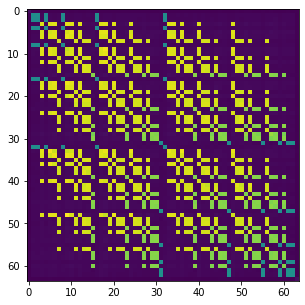

In [25]:
plt.figure(figsize = (5,5))
plt.imshow(model_distribution_res['xy_hat'][:, :300])

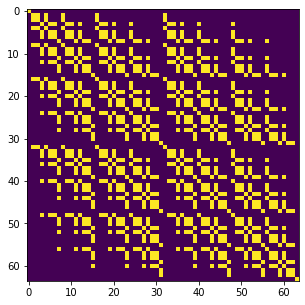

In [26]:
plt.figure(figsize = (5,5))
plt.imshow(xy[:, :300])

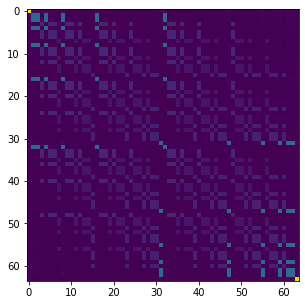

In [27]:
plt.figure(figsize = (5,5))
plt.imshow(model_distribution_res['xy_div_xyind_hat'][:, :300])

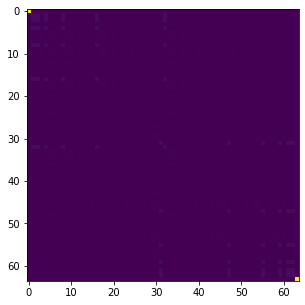

In [28]:
# all
plt.figure(figsize = (5,5))
plt.imshow((xy/xyind)[:, :300])